# Imports

In [50]:
!pip install river==0.16
import yfinance as yf
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from river import metrics
from river import preprocessing
from river import linear_model
from river import tree
from river import forest
from river.neighbors import KNNRegressor

# Data Engineering

In [51]:
# Setting the stocks to predict
stock_symbols = ['GOOGL', 'META', 'AMZN']
stock_ds = [f'dataset_{stock_symbol}.csv' for stock_symbol in stock_symbols]

# Fetching stock data
google = pd.read_csv(stock_ds[0], index_col='timestamp', parse_dates=True)
facebook = pd.read_csv(stock_ds[1], index_col='timestamp', parse_dates=True)
amazon = pd.read_csv(stock_ds[2], index_col='timestamp', parse_dates=True)

# Preprocessing the data (example: using closing prices)
data = pd.DataFrame({
    'Google': google['price'],
    'Facebook': facebook['price'],
    'Amazon': amazon['price'],
    'SP500': google['sp500'],
    'CAC40': google['cac40'],
    'Nikkei': google['nikkei'],
}).dropna()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [52]:
data.dropna(inplace = True)
data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei
Date,,,,,,
2021-01-14,86.545998,245.639999,156.373505,3795.540039,5681.140137,28698.259766
2021-01-15,86.380997,251.360001,155.212494,3768.250000,5611.689941,28519.179688
2021-01-19,89.223503,261.100006,156.037994,3798.909912,5598.609863,28633.460938
2021-01-20,94.003502,267.480011,163.169006,3851.850098,5628.439941,28523.259766
2021-01-21,94.207497,272.869995,165.349503,3853.070068,5590.790039,28756.859375
...,...,...,...,...,...,...
2024-01-05,135.729996,351.950012,145.240005,4697.240234,7420.689941,33377.421875
2024-01-09,140.949997,357.429993,151.369995,4756.500000,7426.620117,33763.179688
2024-01-10,142.279999,370.470001,153.729996,4783.450195,7426.080078,34441.718750


#### Feature engineering

In [53]:
def calculate_technical_indicators(data, companies=['Google', 'Amazon', 'Facebook']):
    """
    Calculate RSI and Moving Averages (SMA and EMA) for specified companies.
    """
    # Calculate RSI
    window_length_rsi = 14
    for company in companies:
        delta = data[company].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.rolling(window_length_rsi).mean()
        roll_down = down.rolling(window_length_rsi).mean()
        RS = roll_up / roll_down
        data[f'{company}_RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate Moving Averages
    sma_ema_windows = [5, 10, 20]
    for company in companies:
        for window in sma_ema_windows:
            data[f'{company}_SMA_{window}'] = data[company].rolling(window=window).mean()
            data[f'{company}_EMA_{window}'] = data[company].ewm(span=window, adjust=False).mean()

    return data

updated_data = calculate_technical_indicators(data)

updated_data.dropna(inplace= True)


In [54]:
data = updated_data
data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei,Google_RSI,Amazon_RSI,Facebook_RSI,Google_SMA_5,...,Amazon_SMA_10,Amazon_EMA_10,Amazon_SMA_20,Amazon_EMA_20,Facebook_SMA_5,Facebook_EMA_5,Facebook_SMA_10,Facebook_EMA_10,Facebook_SMA_20,Facebook_EMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-12,104.751503,270.500000,163.885498,3934.830078,5703.669922,29520.070312,71.560006,48.601808,46.031748,104.302499,...,165.584949,164.875647,163.555999,163.503442,269.300000,269.535539,266.705997,268.217972,266.8605,264.972929
2021-02-16,105.535004,273.970001,163.447495,3932.590088,5786.529785,30467.750000,72.380563,47.619860,45.988873,104.521201,...,165.898698,164.615983,163.909698,163.498114,270.473999,271.013693,268.269998,269.263795,268.2770,265.829793
2021-02-17,105.931000,273.570007,165.432007,3931.330078,5765.839844,30292.189453,72.048140,48.361724,40.924685,104.862201,...,165.727499,164.764351,164.420674,163.682294,271.872003,271.865798,269.425998,270.046743,269.3875,266.566956
2021-02-18,105.290497,269.390015,166.411499,3913.969971,5728.330078,30236.089844,85.720317,60.400578,46.645527,105.166400,...,165.468649,165.063832,164.939349,163.942218,271.860004,271.040537,269.657001,269.927338,269.8020,266.835819
2021-02-19,104.440498,261.559998,162.494995,3906.709961,5773.549805,30017.919922,80.655220,51.151707,45.873323,105.189700,...,165.155499,164.596771,164.905649,163.804388,269.798004,267.880357,269.148001,268.406003,269.5060,266.333360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05,135.729996,351.950012,145.240005,4697.240234,7420.689941,33377.421875,57.279239,48.684757,73.910748,138.481998,...,151.571001,149.622750,149.292500,148.975416,353.835999,351.846309,352.091998,349.577130,339.9175,343.827267
2024-01-09,140.949997,357.429993,151.369995,4756.500000,7426.620117,33763.179688,69.872664,56.649568,72.185082,138.597998,...,151.300999,149.940431,149.619000,149.203471,353.756000,353.707537,353.372998,351.004923,341.7880,345.122764
2024-01-10,142.279999,370.470001,153.729996,4783.450195,7426.080078,34441.718750,71.587333,58.082640,77.556727,139.007999,...,151.295000,150.629442,149.961500,149.634568,356.185999,359.295025,355.384000,354.544028,344.3970,347.536787


# Batch Models

### Linear Regression

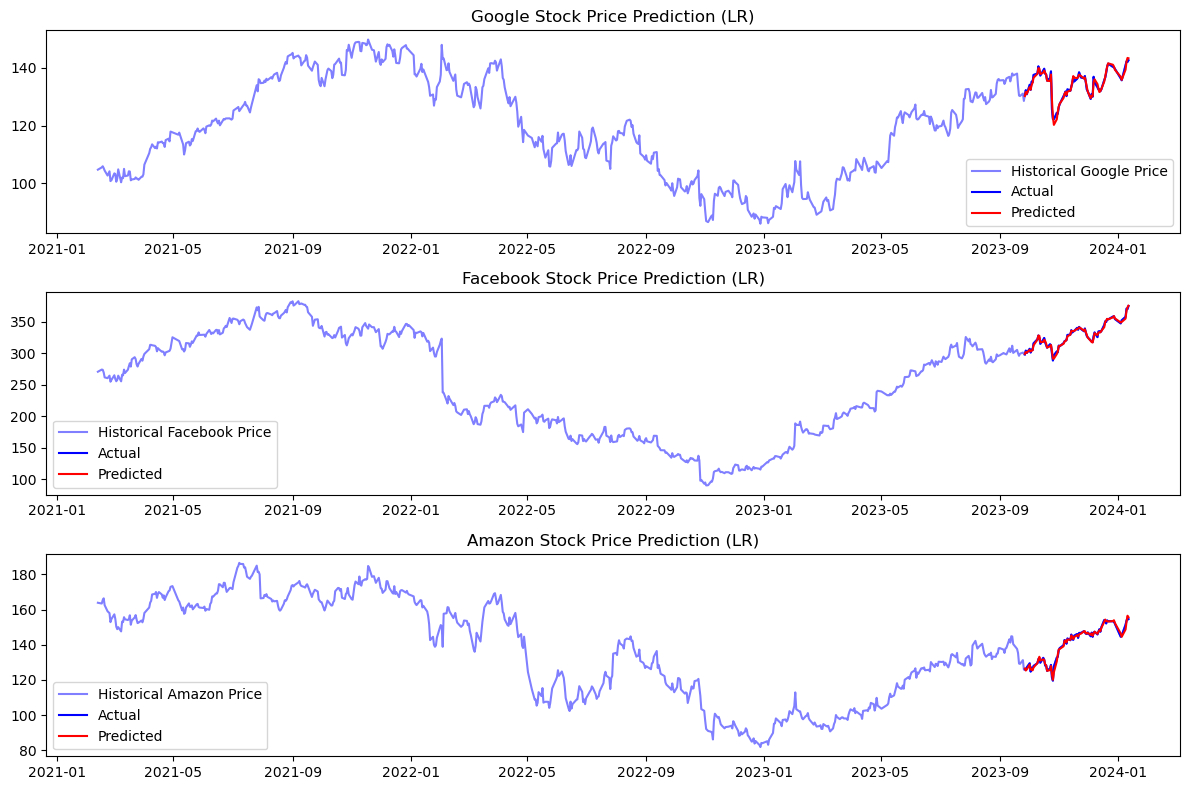

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,0.626004,0.997824,0.700032,0.969100
1,Facebook,5.611384,0.999127,3.892322,0.989511
2,Amazon,1.144614,0.998602,0.867870,0.991350


In [55]:
def create_and_evaluate_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Model training
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))

# Google
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Google'], label=f'Historical Google Price', color='blue', alpha=0.5)
plt.plot(google_y_test.index, google_y_test, label='Actual', color='blue')
plt.plot(google_y_test.index, google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (LR)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Facebook'], label=f'Historical Facebook Price', color='blue', alpha=0.5)
plt.plot(facebook_y_test.index, facebook_y_test, label='Actual', color='blue')
plt.plot(facebook_y_test.index, facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (LR)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Amazon'], label=f'Historical Amazon Price', color='blue', alpha=0.5)
plt.plot(amazon_y_test.index, amazon_y_test, label='Actual', color='blue')
plt.plot(amazon_y_test.index, amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (LR)')
plt.legend()

plt.tight_layout()
plt.show()


results_df

## XGboost

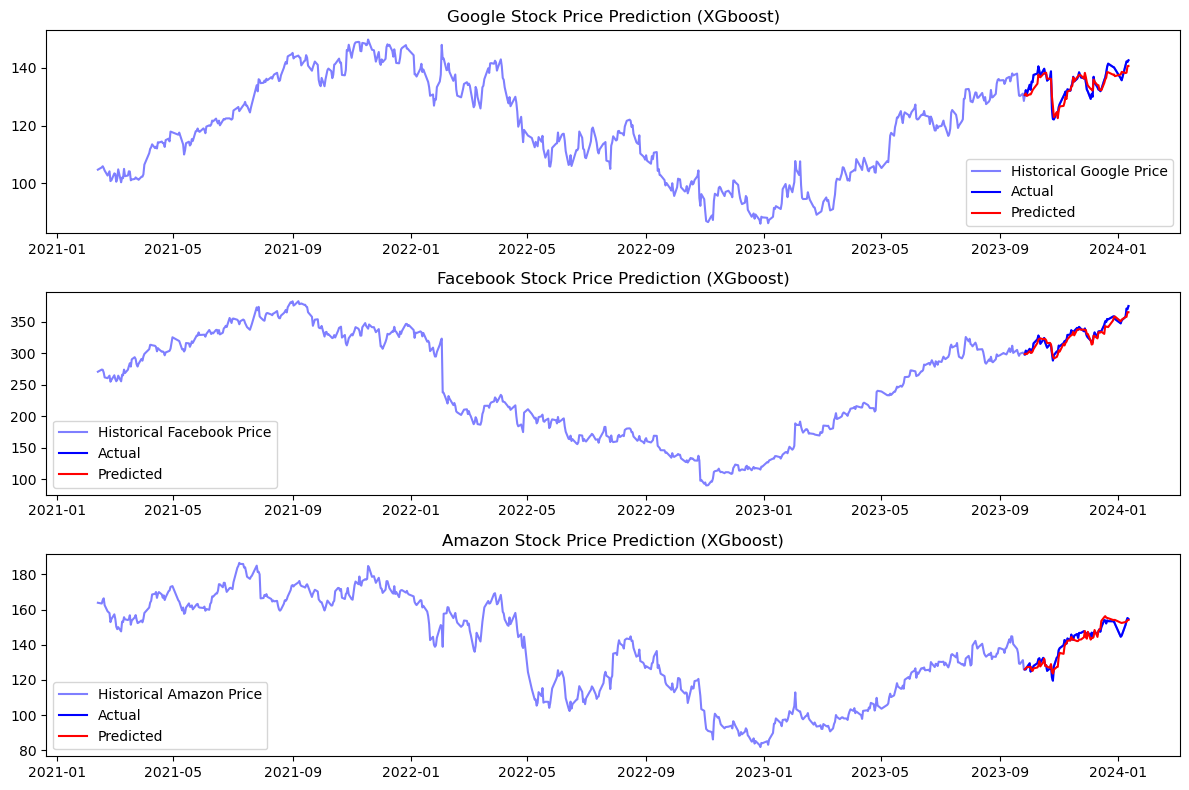

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,0.003271,0.999989,4.091220,0.819410
1,Facebook,0.031177,0.999995,30.736592,0.917168
2,Amazon,0.004329,0.999995,6.913284,0.931096


In [56]:
def create_and_evaluate_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Model training (using XGBoost)
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))

# Google
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Google'], label=f'Historical Google Price', color='blue', alpha=0.5)
plt.plot(google_y_test.index, google_y_test, label='Actual', color='blue')
plt.plot(google_y_test.index, google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (XGboost)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Facebook'], label=f'Historical Facebook Price', color='blue', alpha=0.5)
plt.plot(facebook_y_test.index, facebook_y_test, label='Actual', color='blue')
plt.plot(facebook_y_test.index, facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (XGboost)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Amazon'], label=f'Historical Amazon Price', color='blue', alpha=0.5)
plt.plot(amazon_y_test.index, amazon_y_test, label='Actual', color='blue')
plt.plot(amazon_y_test.index, amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (XGboost)')
plt.legend()

plt.tight_layout()
plt.show()

results_df


## LSTM

Epoch 1/50
20/20 [==============================] - 1s 1ms/step - loss: 0.1686
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0178
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 6/50
20/20 [==============================] - 0s 867us/step - loss: 0.0047
Epoch 7/50
20/20 [==============================] - 0s 793us/step - loss: 0.0037
Epoch 8/50
20/20 [==============================] - 0s 874us/step - loss: 0.0031
Epoch 9/50
20/20 [==============================] - 0s 951us/step - loss: 0.0026
Epoch 10/50
20/20 [==============================] - 0s 908us/step - loss: 0.0023
Epoch 11/50
20/20 [==============================] - 0s 893us/step - loss: 0.0021
Epoch 12/50
20/20 [==============================] - 0s 861us/step - loss: 0.0019
Epoch 13/50
20/20 [================

Epoch 1/50
20/20 [==============================] - 1s 2ms/step - loss: 0.1439
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 5/50
20/20 [==============================] - 0s 991us/step - loss: 0.0038
Epoch 6/50
20/20 [==============================] - 0s 947us/step - loss: 0.0030
Epoch 7/50
20/20 [==============================] - 0s 854us/step - loss: 0.0024
Epoch 8/50
20/20 [==============================] - 0s 871us/step - loss: 0.0020
Epoch 9/50
20/20 [==============================] - 0s 967us/step - loss: 0.0017
Epoch 10/50
20/20 [==============================] - 0s 925us/step - loss: 0.0016
Epoch 11/50
20/20 [==============================] - 0s 923us/step - loss: 0.0014
Epoch 12/50
20/20 [==============================] - 0s 847us/step - loss: 0.0013
Epoch 13/50
20/20 [==============

Epoch 1/50
20/20 [==============================] - 1s 2ms/step - loss: 0.2714
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 5/50
20/20 [==============================] - 0s 992us/step - loss: 0.0044
Epoch 6/50
20/20 [==============================] - 0s 846us/step - loss: 0.0035
Epoch 7/50
20/20 [==============================] - 0s 833us/step - loss: 0.0029
Epoch 8/50
20/20 [==============================] - 0s 864us/step - loss: 0.0024
Epoch 9/50
20/20 [==============================] - 0s 878us/step - loss: 0.0021
Epoch 10/50
20/20 [==============================] - 0s 842us/step - loss: 0.0019
Epoch 11/50
20/20 [==============================] - 0s 841us/step - loss: 0.0018
Epoch 12/50
20/20 [==============================] - 0s 828us/step - loss: 0.0016
Epoch 13/50
20/20 [==============

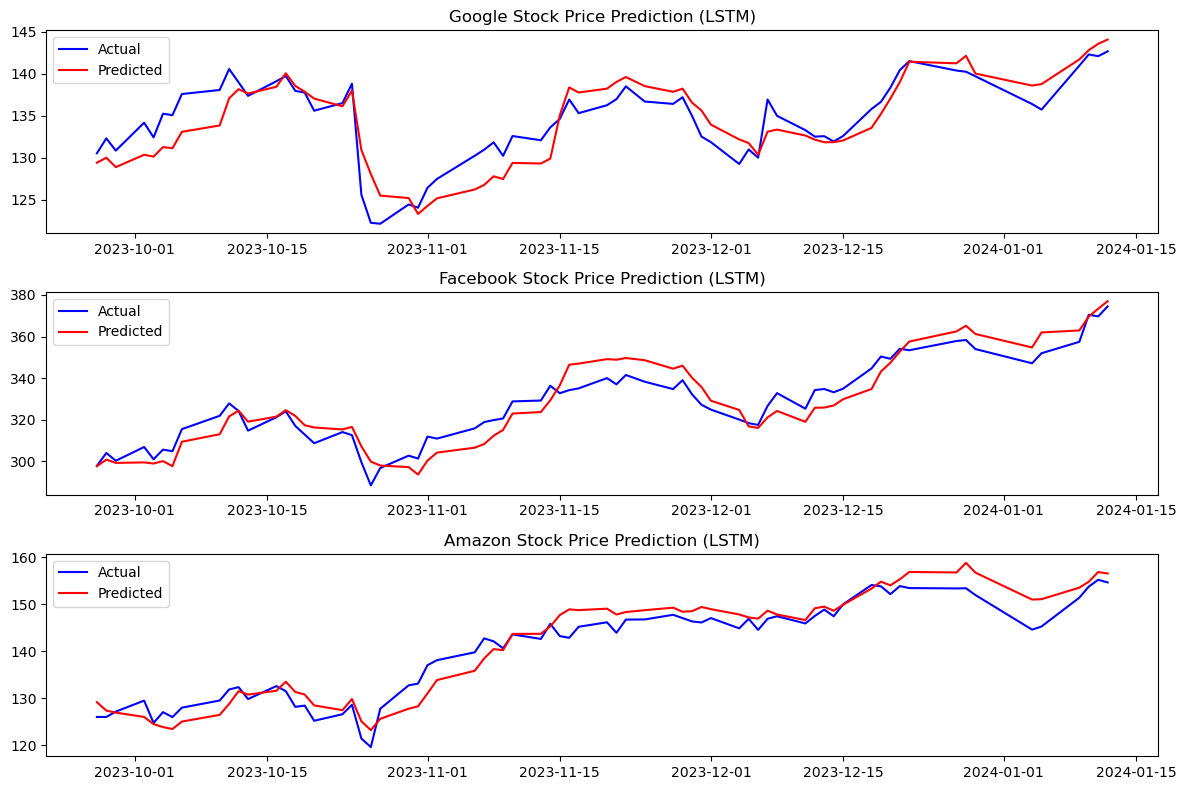

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,3.829335,0.986690,5.671202,0.749668
1,Facebook,44.774319,0.993033,46.341331,0.875115
2,Amazon,10.351930,0.987360,8.534791,0.914934


In [57]:
def create_and_evaluate_lstm_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Normalize the data
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    target = scaler.fit_transform(target.values.reshape(-1, 1))

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Reshape data for LSTM
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Create an LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

    # Model training
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Inverse transform to get original scale
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate LSTM models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_lstm_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_lstm_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_lstm_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))


# Google
plt.subplot(3, 1, 1)
plt.plot(data.index[-len(google_y_test):], google_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(google_y_test):], google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (LSTM)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index[-len(facebook_y_test):], facebook_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(facebook_y_test):], facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (LSTM)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index[-len(amazon_y_test):], amazon_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(amazon_y_test):], amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

results_df


# Online Models (River)

## LinearRegression

Best hyperparameters for Google: {'grace_period': None, 'model_selector_decay': None, 'max_depth': None, 'intercept_lr': 0.1, 'optimizer': SGD({'lr': Constant({'learning_rate': 0.01}), 'n_iterations': 2055})}
Best MSE for Google: 47.36583272829576


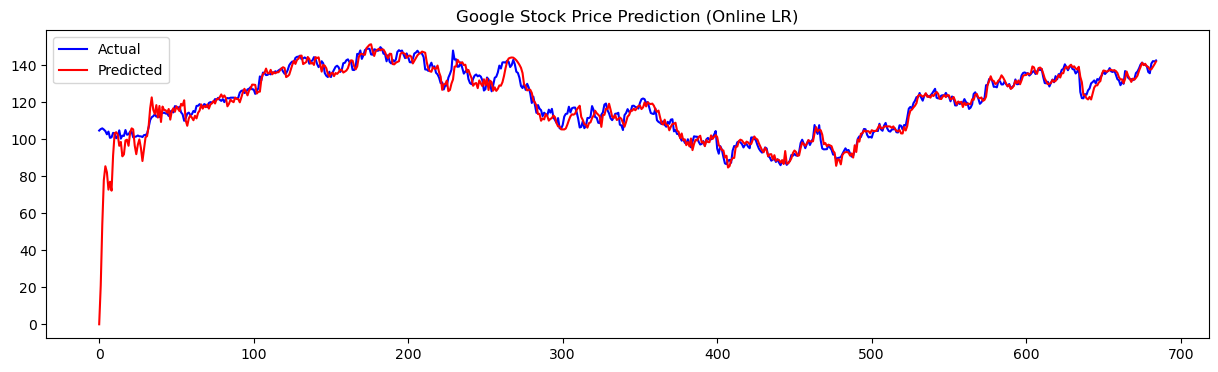

Best hyperparameters for Facebook: {'grace_period': None, 'model_selector_decay': None, 'max_depth': None, 'intercept_lr': 0.1, 'optimizer': SGD({'lr': Constant({'learning_rate': 0.01}), 'n_iterations': 4795})}
Best MSE for Facebook: 337.8549663365501


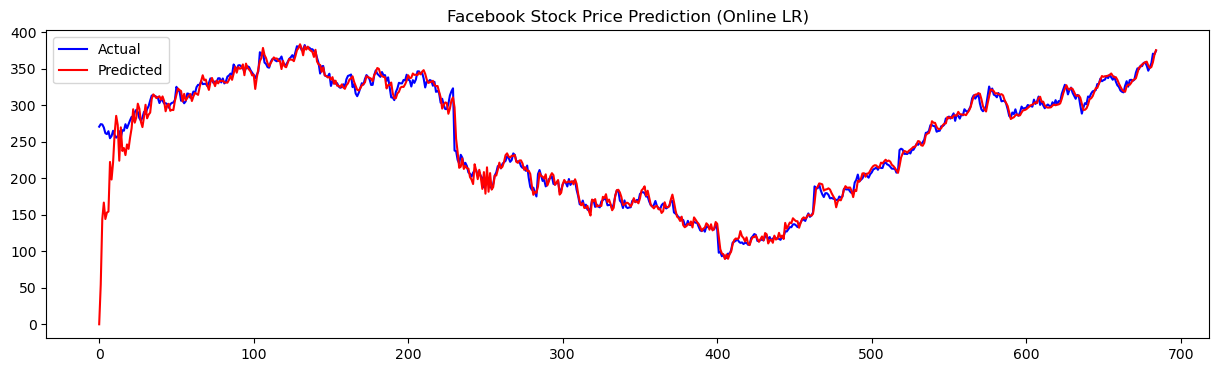

Best hyperparameters for Amazon: {'grace_period': None, 'model_selector_decay': None, 'max_depth': None, 'intercept_lr': 0.1, 'optimizer': RMSProp({'lr': Constant({'learning_rate': 0.01}), 'n_iterations': 6165, 'rho': 0.9, 'eps': 1e-08, 'g2': {'Google_RSI': 4.789777638014658e-185, 'Google_SMA_5': 5.532502302406823e-185, 'Google_EMA_5': 5.6842085946451157e-185, 'Google_SMA_10': 5.2664205605965505e-185, 'Google_EMA_10': 5.293160480041438e-185, 'Google_SMA_20': 4.421276945595586e-185, 'Google_EMA_20': 4.880368925492822e-185, 'SP500': 36427.1276671546, 'CAC40': 26349.54475632641, 'Nikkei': 60397.8258071882, 'Facebook_RSI': 1.3343071242597086e-89, 'Facebook_SMA_5': 1.2318714271353516e-89, 'Facebook_EMA_5': 1.2520082920987309e-89, 'Facebook_SMA_10': 1.1609112551144366e-89, 'Facebook_EMA_10': 1.1704929321328149e-89, 'Facebook_SMA_20': 9.988961001970807e-90, 'Facebook_EMA_20': 1.0676401263731416e-89, 'Amazon_RSI': 5124.344494908868, 'Amazon_SMA_5': 2541.2126267667336, 'Amazon_EMA_5': 2679.6781

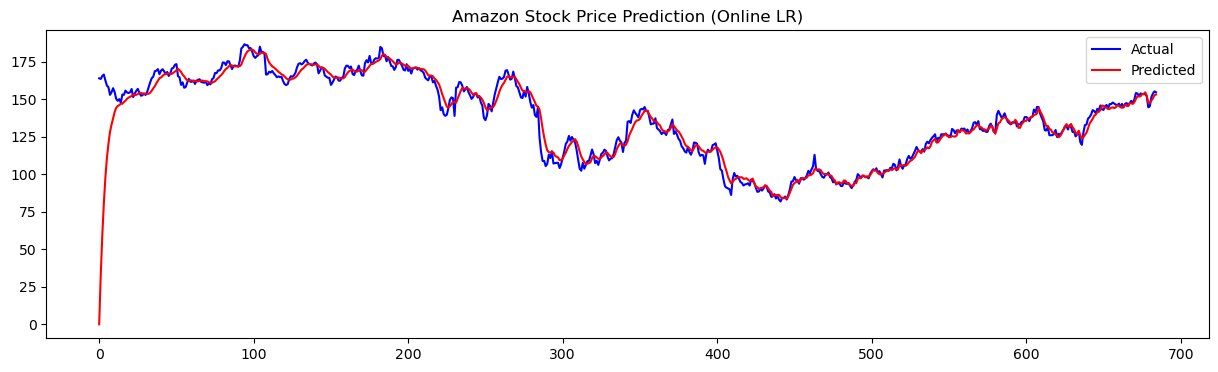

,Google,Facebook,Amazon
MSE,47.365833,337.854966,122.572758
MA,3.050079,6.932778,3.993977
R^2,0.832873,0.947279,0.836043


In [58]:
from river import optim

def create_and_evaluate_online_model(stock_name, data, intercept_lr, optimizer):

    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = (preprocessing.StandardScaler() | 
            linear_model.LinearRegression(
                intercept_lr=intercept_lr,
                optimizer=optimizer
            )
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


# Define the hyperparameter grid
param_grid = {
    'intercept_lr': [0.1, 0.01, 0.001],
    'optimizer': [optim.SGD(0.01), optim.Adam(0.01), optim.RMSProp(0.01)],
}

results = {
    'Google': {'MSE': None, 'MA': None, 'R^2': None},
    'Facebook': {'MSE': None, 'MA': None, 'R^2': None},
    'Amazon': {'MSE': None, 'MA': None, 'R^2': None}
}

# Perform hyperparameter tuning for each stock
for stock_name in ['Google', 'Facebook', 'Amazon']:
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name
    stock_data = data[feature_cols + [target_col]]

    # Initialize the best hyperparameters and metrics
    best_hyperparams = {'grace_period': None, 'model_selector_decay': None, 'max_depth': None}
    best_mse = float('inf')

    # Iterate over hyperparameter grid
    for intercept_lr in param_grid['intercept_lr']:
        for optimizer in param_grid['optimizer']:
            predictions, actuals, mse, _, _ = create_and_evaluate_online_model(stock_name, data, intercept_lr, optimizer)

            # Update best hyperparameters if the current configuration has lower MSE
            if mse < best_mse:
                best_mse = mse
                best_hyperparams['intercept_lr'] = intercept_lr
                best_hyperparams['optimizer'] = optimizer

    print(f"Best hyperparameters for {stock_name}: {best_hyperparams}")
    print(f"Best MSE for {stock_name}: {best_mse}")

    # Create and evaluate the model with the best hyperparameters
    predictions, actuals, mse, r2, ma = create_and_evaluate_online_model(stock_name, stock_data, best_hyperparams['intercept_lr'], best_hyperparams['optimizer'])
    results[stock_name]['MSE'] = mse
    results[stock_name]['MA'] = ma
    results[stock_name]['R^2'] = r2

    # Visualize the predictions
    plt.figure(figsize=(15, 4))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{stock_name} Stock Price Prediction (Online LR)')
    plt.legend()
    plt.show()

# Creating a DataFrame with results
results_df_online_LR = pd.DataFrame(results)
results_df_online_LR

## HoeffdingTreeRegressor

Best hyperparameters for Google: {'grace_period': 100, 'model_selector_decay': 0.7, 'max_depth': 5}
Best MSE for Google: 126.23446653172334


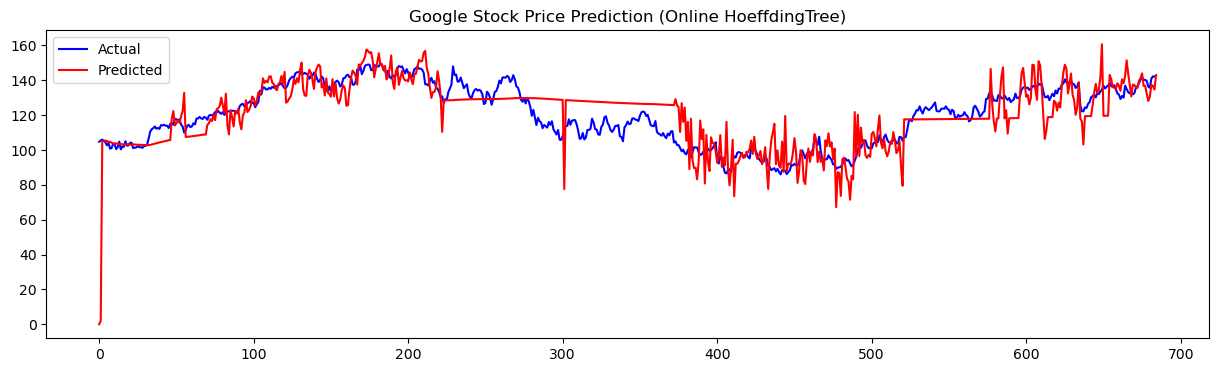

Best hyperparameters for Facebook: {'grace_period': 100, 'model_selector_decay': 0.5, 'max_depth': 5}
Best MSE for Facebook: 1085.9695040052648


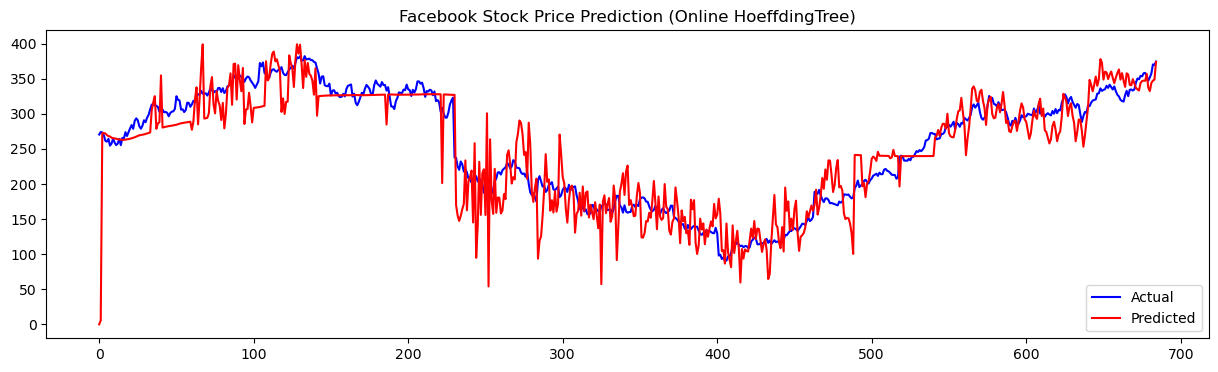

Best hyperparameters for Amazon: {'grace_period': 300, 'model_selector_decay': 0.5, 'max_depth': 5}
Best MSE for Amazon: 253.4536257273928


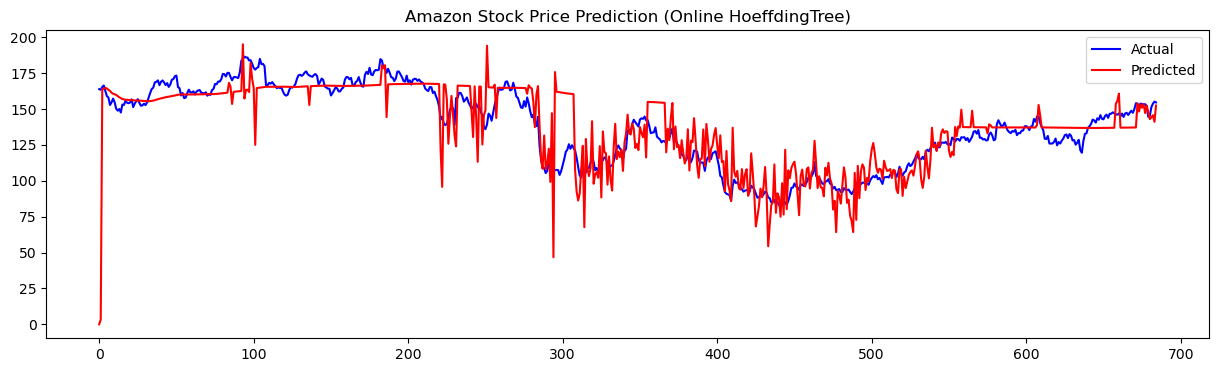

,Google,Facebook,Amazon
MSE,126.234467,1085.969504,253.453626
MA,7.913567,22.835197,9.758583
R^2,0.554590,0.830539,0.660973


In [59]:
def create_and_evaluate_online_model(stock_name, data, grace_period, model_selector_decay, max_depth):
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = (
        preprocessing.StandardScaler() |
        tree.HoeffdingTreeRegressor(
            grace_period=grace_period,
            model_selector_decay=model_selector_decay,
            max_depth=max_depth)
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


# Define the hyperparameter grid
param_grid = {
    'grace_period': [100, 200, 300],
    'model_selector_decay': [0.5, 0.6, 0.7],
    'max_depth': [5, 10, 15]
}

results = {
    'Google': {'MSE': None, 'MA': None, 'R^2': None},
    'Facebook': {'MSE': None, 'MA': None, 'R^2': None},
    'Amazon': {'MSE': None, 'MA': None, 'R^2': None}
}

# Perform hyperparameter tuning for each stock
for stock_name in ['Google', 'Facebook', 'Amazon']:
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name
    stock_data = data[feature_cols + [target_col]]

    # Initialize the best hyperparameters and metrics
    best_hyperparams = {'grace_period': None, 'model_selector_decay': None, 'max_depth': None}
    best_mse = float('inf')

    # Iterate over hyperparameter grid
    for grace_period in param_grid['grace_period']:
        for model_selector_decay in param_grid['model_selector_decay']:
            for max_depth in param_grid['max_depth']:
                predictions, actuals, mse, _, _ = create_and_evaluate_online_model(stock_name, data, grace_period, model_selector_decay, max_depth)

                # Update best hyperparameters if the current configuration has lower MSE
                if mse < best_mse:
                    best_mse = mse
                    best_hyperparams['model_selector_decay'] = model_selector_decay
                    best_hyperparams['grace_period'] = grace_period
                    best_hyperparams['max_depth'] = max_depth

    print(f"Best hyperparameters for {stock_name}: {best_hyperparams}")
    print(f"Best MSE for {stock_name}: {best_mse}")

    # Create and evaluate the model with the best hyperparameters
    predictions, actuals, mse, r2, ma = create_and_evaluate_online_model(stock_name, stock_data, best_hyperparams['grace_period'], best_hyperparams['model_selector_decay'], best_hyperparams['max_depth'])
    results[stock_name]['MSE'] = mse
    results[stock_name]['MA'] = ma
    results[stock_name]['R^2'] = r2

    # Visualize the predictions
    plt.figure(figsize=(15, 4))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{stock_name} Stock Price Prediction (Online HoeffdingTree)')
    plt.legend()
    plt.show()

# Creating a DataFrame with results
results_df_online_HTR = pd.DataFrame(results)
results_df_online_HTR


## ARFRegressor

Best hyperparameters for Google: {'n_models': 50, 'grace_period': 10}
Best MSE for Google: 93.64869060700678


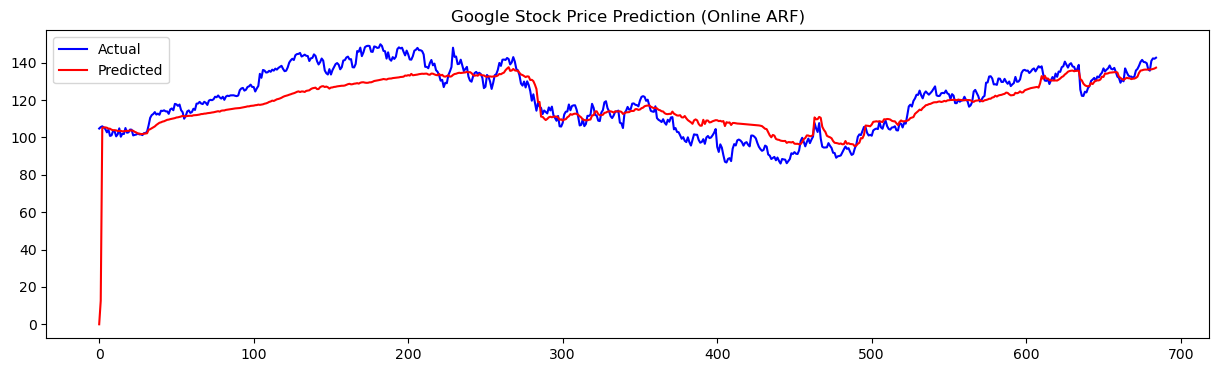

Best hyperparameters for Facebook: {'n_models': 10, 'grace_period': 10}
Best MSE for Facebook: 1061.4018445558504


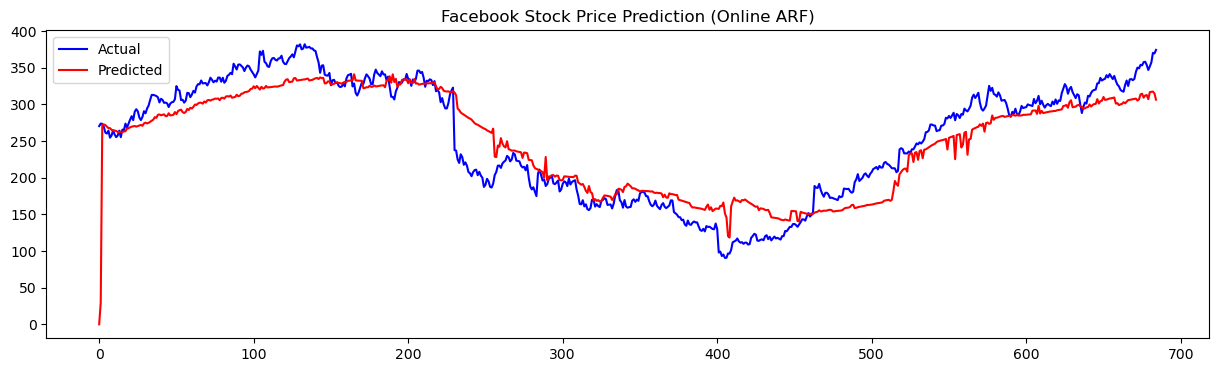

Best hyperparameters for Amazon: {'n_models': 100, 'grace_period': 10}
Best MSE for Amazon: 185.16505336647342


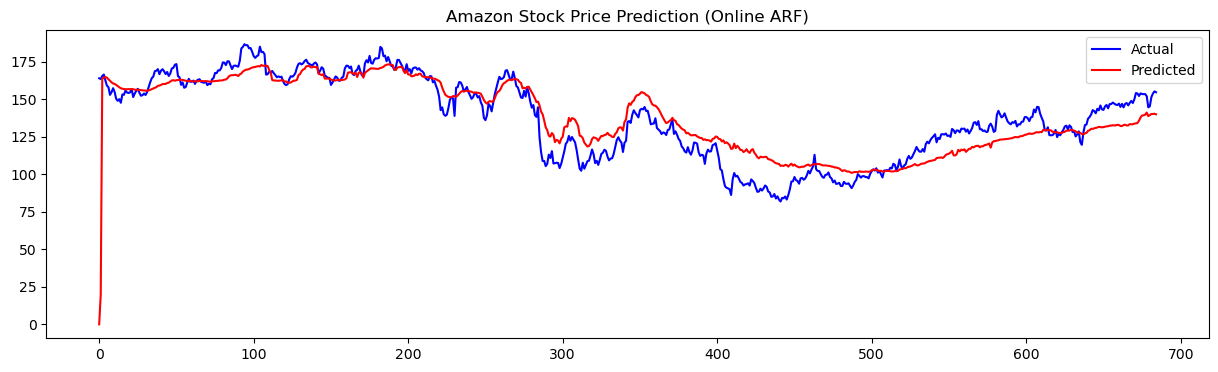

,Google,Facebook,Amazon
MSE,97.102544,1059.582888,186.276943
MA,6.850962,24.825253,9.153902
R^2,0.657380,0.834657,0.750830


In [60]:
def create_and_evaluate_online_model(stock_name, data, n_models, grace_period):
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = (
        preprocessing.StandardScaler() |
        forest.ARFRegressor(n_models=n_models, grace_period=grace_period)
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


# Define the hyperparameter grid
param_grid = {
    'n_models': [10, 50, 100],
    'grace_period': [10, 50, 100]
}

results = {
    'Google': {'MSE': None, 'MA': None, 'R^2': None},
    'Facebook': {'MSE': None, 'MA': None, 'R^2': None},
    'Amazon': {'MSE': None, 'MA': None, 'R^2': None}
}

# Perform hyperparameter tuning for each stock
for stock_name in ['Google', 'Facebook', 'Amazon']:
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name
    stock_data = data[feature_cols + [target_col]]

    # Initialize the best hyperparameters and metrics
    best_hyperparams = {'n_models': None, 'grace_period': None}
    best_mse = float('inf')

    # Iterate over hyperparameter grid
    for n_models in param_grid['n_models']:
        for grace_period in param_grid['grace_period']:
            predictions, actuals, mse, _, _ = create_and_evaluate_online_model(stock_name, data, n_models, grace_period)

            # Update best hyperparameters if the current configuration has lower MSE
            if mse < best_mse:
                best_mse = mse
                best_hyperparams['n_models'] = n_models
                best_hyperparams['grace_period'] = grace_period

    print(f"Best hyperparameters for {stock_name}: {best_hyperparams}")
    print(f"Best MSE for {stock_name}: {best_mse}")

    # Create and evaluate the model with the best hyperparameters
    predictions, actuals, mse, r2, ma = create_and_evaluate_online_model(stock_name, stock_data, best_hyperparams['n_models'], best_hyperparams['grace_period'])
    results[stock_name]['MSE'] = mse
    results[stock_name]['MA'] = ma
    results[stock_name]['R^2'] = r2

    # Visualize the predictions
    plt.figure(figsize=(15, 4))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{stock_name} Stock Price Prediction (Online ARF)')
    plt.legend()
    plt.show()

# Creating a DataFrame with results
results_df_online_AFR = pd.DataFrame(results)
results_df_online_AFR

## KNNRegressor

Best hyperparameters for Google: {'n_neighbors': 5, 'window_size': 20}
Best MSE for Google: 24.51099688780946


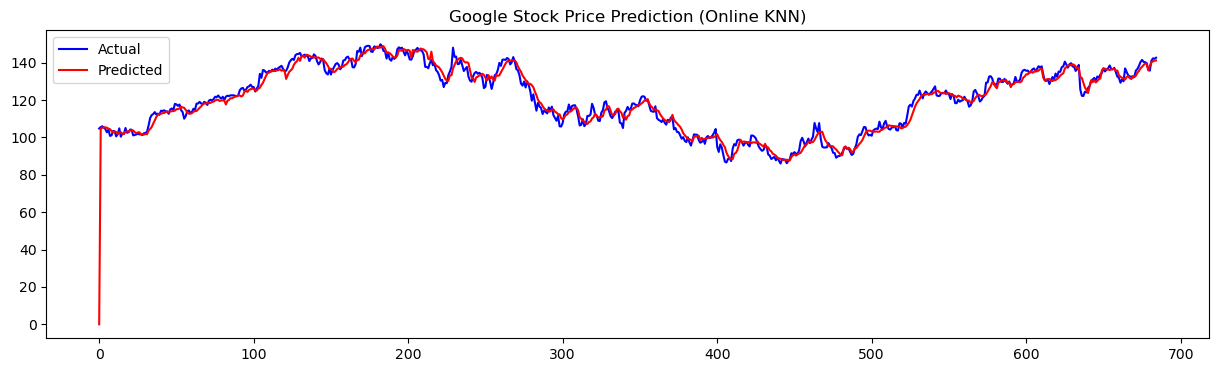

Best hyperparameters for Facebook: {'n_neighbors': 5, 'window_size': 10}
Best MSE for Facebook: 192.13185630612344


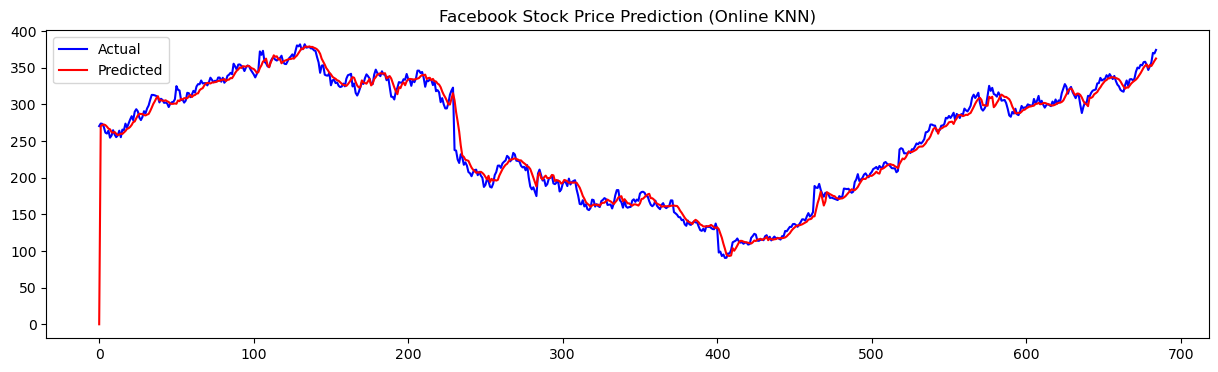

Best hyperparameters for Amazon: {'n_neighbors': 5, 'window_size': 100}
Best MSE for Amazon: 58.699116968409044


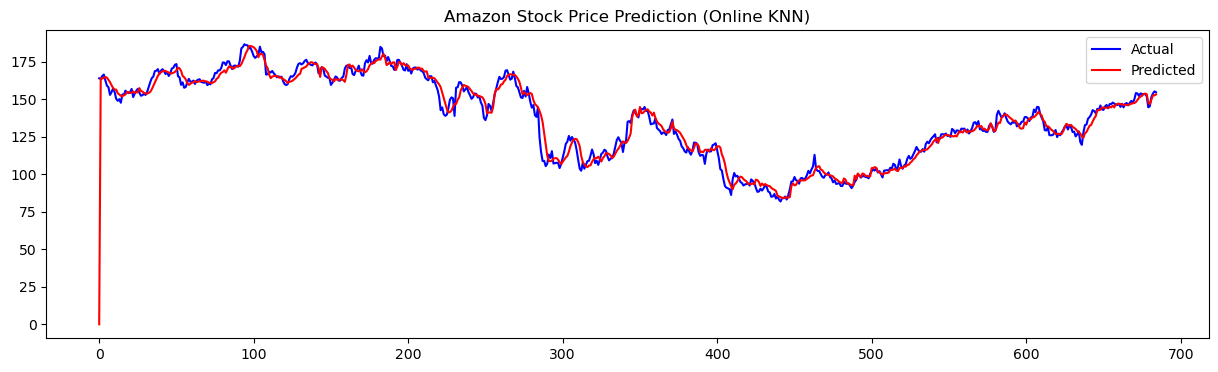

,Google,Facebook,Amazon
MSE,24.510997,192.131856,58.699117
MA,2.400757,7.000716,3.441754
R^2,0.913514,0.970019,0.921482


In [61]:
def create_and_evaluate_online_model(stock_name, data, n_neighbors, window_size):
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = (
        preprocessing.StandardScaler() |
        KNNRegressor(n_neighbors=n_neighbors, window_size=window_size)
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [5, 10, 15],
    'window_size': [5, 10, 20, 50, 100]
}

results = {
    'Google': {'MSE': None, 'MA': None, 'R^2': None},
    'Facebook': {'MSE': None, 'MA': None, 'R^2': None},
    'Amazon': {'MSE': None, 'MA': None, 'R^2': None}
}

# Perform hyperparameter tuning for each stock
for stock_name in ['Google', 'Facebook', 'Amazon']:
    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name
    stock_data = data[feature_cols + [target_col]]

    # Initialize the best hyperparameters and metrics
    best_hyperparams = {'n_neighbors': None, 'window_size': None}
    best_mse = float('inf')

    # Iterate over hyperparameter grid
    for n_neighbors in param_grid['n_neighbors']:
        for window_size in param_grid['window_size']:
            predictions, actuals, mse, _, _ = create_and_evaluate_online_model(stock_name, data, n_neighbors, window_size)

            # Update best hyperparameters if the current configuration has lower MSE
            if mse < best_mse:
                best_mse = mse
                best_hyperparams['n_neighbors'] = n_neighbors
                best_hyperparams['window_size'] = window_size

    print(f"Best hyperparameters for {stock_name}: {best_hyperparams}")
    print(f"Best MSE for {stock_name}: {best_mse}")

    # Create and evaluate the model with the best hyperparameters
    predictions, actuals, mse, r2, ma = create_and_evaluate_online_model(stock_name, stock_data, best_hyperparams['n_neighbors'], best_hyperparams['window_size'])
    results[stock_name]['MSE'] = mse
    results[stock_name]['MA'] = ma
    results[stock_name]['R^2'] = r2

    # Visualize the predictions
    plt.figure(figsize=(15, 4))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f'{stock_name} Stock Price Prediction (Online KNN)')
    plt.legend()
    plt.show()

# Creating a DataFrame with results
results_df_online_KNN = pd.DataFrame(results)
results_df_online_KNN

In [62]:
# concatenate results
results_df = pd.concat({'LR': results_df_online_LR, 'HTR': results_df_online_HTR, 'AFR': results_df_online_AFR, 'KNN': results_df_online_KNN}, axis=0)
results_df = results_df[['Google', 'Facebook', 'Amazon']].unstack()
results_df

Google                         Facebook                       \
            MSE        MA       R^2          MSE         MA       R^2   
LR    47.365833  3.050079  0.832873   337.854966   6.932778  0.947279   
HTR  126.234467  7.913567  0.554590  1085.969504  22.835197  0.830539   
AFR   97.102544  6.850962  0.657380  1059.582888  24.825253  0.834657   
KNN   24.510997  2.400757  0.913514   192.131856   7.000716  0.970019   

         Amazon                      
            MSE        MA       R^2  
LR   122.572758  3.993977  0.836043  
HTR  253.453626  9.758583  0.660973  
AFR  186.276943  9.153902  0.750830  
KNN   58.699117  3.441754  0.921482